## Read and Write

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'/data/private/Thesis/Thesees'

In [3]:
ds = gdal.Open("Data/01_Preprocessed/c2_clip.tif")

In [4]:
gt = ds.GetGeoTransform()
print(gt)

(622290.0, 10.0, 0.0, 213240.0, 0.0, -10.0)


In [7]:
proj = ds.GetProjection()
print(proj)

PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32647"]]


In [6]:
nband = ds.RasterCount
print(nband)
bandvv = ds.GetRasterBand(1)

4


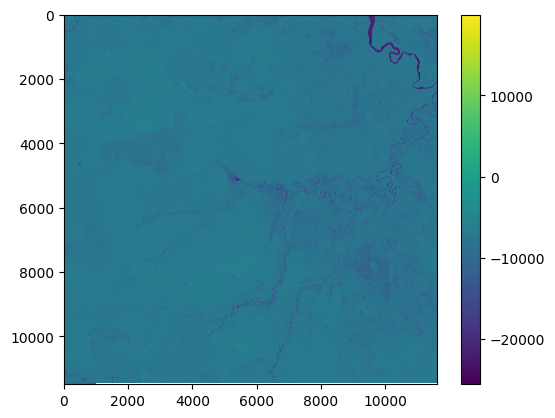

In [16]:
array = bandvv.ReadAsArray()
plt.figure()
plt.imshow(array)
plt.colorbar()

In [14]:
#binmask = np.where((array >= np.mean(array)),1,0)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("binmask.tif", xsize=binmask.shape[1],
                     ysize=binmask.shape[0], bands=1,
                     eType=gdal.GDT_Int16)

outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.writeArray(binmask)
outband.SetNoDataValue(np.nan)
outband.FlushCache()
outband = None
outds = None

In [ ]:
#rowcolumn
binmask.shape

## Reproject, resample, clip

In [ ]:
dsReprj = gdal.Warp("demReprj", ds, dstSRS="EPSG:4326")

In [ ]:
dsRes = gdal.Warp("demRes.tif", ds, xRes=100, yRes=100)
#resampleAlg="bilinear"

In [ ]:
dsClip = gdal.Warp("demClip.tif", ds, cutlineDSName="star.shp",
                  cropToCutline=True, dstNodata=np.nan)

In [ ]:
ds = dsClip = dsRes = dsReprj = None

## Split raster into equally-size pieces

In [17]:
from osgeo import gdal

In [7]:
gt = ds.GetGeoTransform()
print(gt)

(622290.0, 10.0, 0.0, 213240.0, 0.0, -10.0)


In [8]:
xmin = gt[0]
ymax = gt[3]
res = gt[1]
xlen = res * ds.RasterXSize
ylen = res * ds.RasterYSize
print(xlen)

181650.0


In [9]:
xdiv = 3
ydiv = 2

xsize = xlen/xdiv
ysize = ylen/ydiv

In [10]:
xsteps = [xmin + xsize * i for i in range(xdiv+1)]
ysteps = [ymax - ysize * i for i in range(ydiv+1)]

In [12]:
for i in range(xdiv):
    for j in range(ydiv):
        xmin = xsteps[i]
        xmax = xsteps[i+1]
        ymax = ysteps[j]
        ymin = ysteps[j+1]
        
        print("xmin: "+str(xmin))
        print("xmax: "+str(xmax))
        print("ymin: "+str(ymin))
        print("ymax: "+str(ymax))
        print("\n")
        
        gdal.Warp("Data/02_Tile/c2/c2"+str(i)+str(j)+".tif", ds, xRes=res, yRes=-res,
                  outputBounds=(xmin,ymin,xmax,ymax), dstNodata=-9999)

xmin: 622290.0
xmax: 682840.0
ymin: 154210.0
ymax: 213240.0


xmin: 622290.0
xmax: 682840.0
ymin: 95180.0
ymax: 154210.0


xmin: 682840.0
xmax: 743390.0
ymin: 154210.0
ymax: 213240.0


xmin: 682840.0
xmax: 743390.0
ymin: 95180.0
ymax: 154210.0


xmin: 743390.0
xmax: 803940.0
ymin: 154210.0
ymax: 213240.0


xmin: 743390.0
xmax: 803940.0
ymin: 95180.0
ymax: 154210.0




In [ ]:
#close the open dataset
ds = None

In [25]:
ls

01_Exploration.ipynb  Data/  Raster_gdal.ipynb  Trial/


## Merge raster data

In [26]:
from osgeo import gdal
import glob
import subprocess

In [ ]:
dslist = glob.glob("dem[0-9][0-9].tif")
print(dslist)

In [ ]:
#merge by merge
cmd = "gdal_merge.py -ps 10 -10 -o mergedDS.tif"
subprocess.call(cmd.split()+dslist)

In [ ]:
#merge with virtual raster (lighter)
vrt = gdal.BuildVRT("merged.vrt", dslist)
gdal.Translate("mergedDS2.tif", vrt, xRes=10, yRes=-10)
vrt = None

## Visualizing multi-band satellite images

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ds = gdal.Open("Trial/Images/S2.tif")

In [5]:
r = ds.GetRasterBand(3).ReadAsArray()
g = ds.GetRasterBand(2).ReadAsArray()
b = ds.GetRasterBand(1).ReadAsArray()

In [37]:
rgb = np.dstack((r,g,b))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


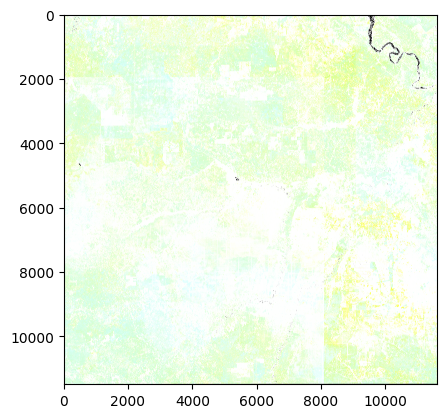

In [38]:
plt.figure()
plt.imshow(rgb)
plt.show()

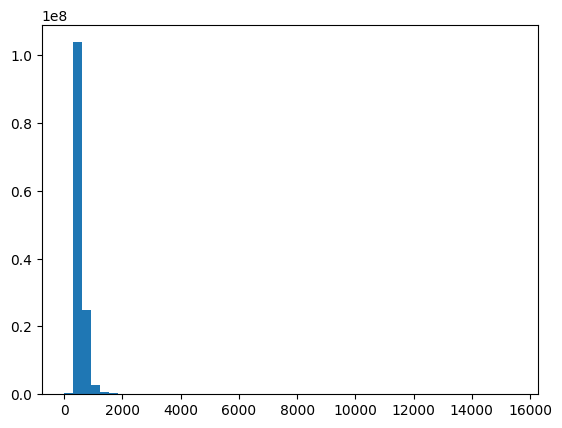

In [44]:
plt.figure()
plt.hist(g.flatten(), bins=50)
plt.show()

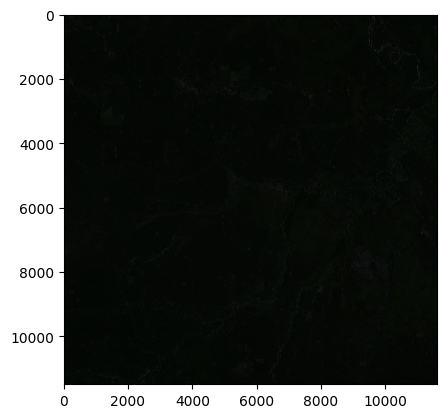

In [4]:
#rescaling

#min-max normalization
def scaleMinMax(x):
    return((x - np.nanmin(x))/(np.nanmax(x) - np.nanmin(x)))

r = scaleMinMax(r)
g = scaleMinMax(g)
b = scaleMinMax(b)
           
rgb = np.dstack((r,g,b))
plt.figure()
plt.imshow(rgb)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


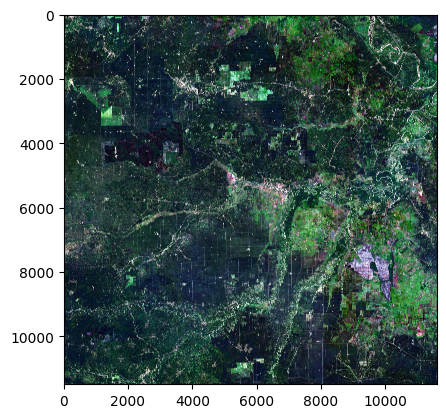

In [6]:
#rescaling
r = ds.GetRasterBand(3).ReadAsArray()
g = ds.GetRasterBand(2).ReadAsArray()
b = ds.GetRasterBand(1).ReadAsArray()

#98 percentile
def scaleCCC(x):
    return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x, 2)))

r = scaleCCC(r)
g = scaleCCC(g)
b = scaleCCC(b)
           
rgb = np.dstack((r,g,b))
plt.figure()
plt.imshow(rgb)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


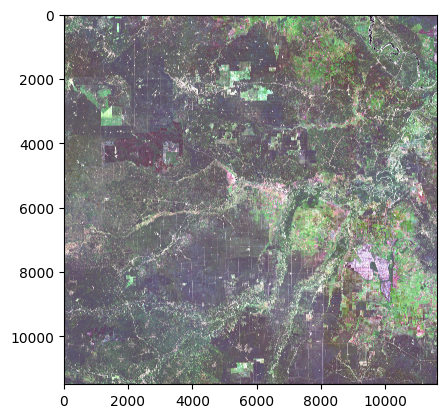

In [7]:
#rescaling
r = ds.GetRasterBand(3).ReadAsArray()
g = ds.GetRasterBand(2).ReadAsArray()
b = ds.GetRasterBand(1).ReadAsArray()

#std
def scaleStd(x):
    return((x - (np.nanmean(x)-np.nanstd(x)*2))/((np.nanmean(x)+np.nanstd(x)*2) - (np.nanmean(x)-np.nanstd(x)*2)))

r = scaleStd(r)
g = scaleStd(g)
b = scaleStd(b)
           
rgb = np.dstack((r,g,b))
plt.figure()
plt.imshow(rgb)
plt.show()

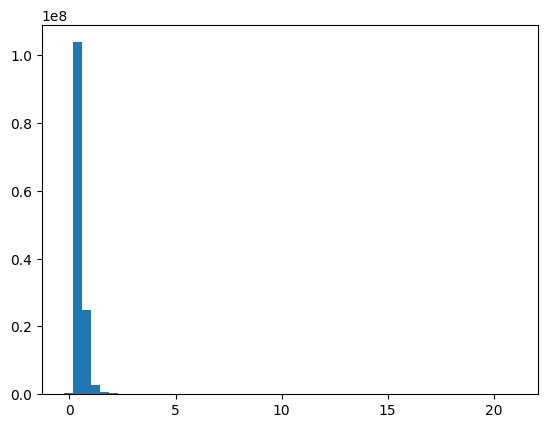

In [8]:
plt.figure()
plt.hist(g.flatten(), bins=50)
plt.show()